In [2]:
#import all necessary modules
from __future__ import print_function
import logging
from optparse import OptionParser
import sys
from time import time
import matplotlib.pyplot as plt
import os
import nltk
import string
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.tokenize import RegexpTokenizer
import re
import numpy as np
from numpy import array
from numpy import argmax
import string
import pandas as pd
from sklearn.model_selection import train_test_split 
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import f_classif
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.svm import SVC 
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.utils.extmath import density
from sklearn.decomposition import PCA
from sklearn import metrics
import warnings
warnings.simplefilter('ignore')

In [3]:
#These parameters will be input from command line
ngram_range_inp=(1,2)
filename = "D:/Pepsico/generic_PDAF_Turgay_updated.xlsx"
#n_components = 0

# Text Normalization

In [4]:
exclude = set(string.punctuation) 
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')
newStopWords = ['from']
stop_words.extend(newStopWords)
table = str.maketrans('', '', string.punctuation)

porter = PorterStemmer()

def normalize_document(doc):
    # tokenize document
    tokens = doc.split()
    # remove punctuation from each word
    tokens = [w.translate(table) for w in tokens]
    # convert to lower case
    lower_tokens = [w.lower() for w in tokens]
    #remove spaces
    stripped = [w.strip() for w in lower_tokens]
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # filter stopwords out of document
    filtered_tokens = [token for token in words if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

In [5]:
fsha_data = pd.read_excel(filename)

In [6]:
fsha_data.columns

Index(['projName', 'accolNumber', 'PDA_projName', 'projType', ' projDesc',
       'formulaNumber', 'owner', ' sector', 'Unnamed: 8', 'Unnamed: 9',
       ' center', ' cur_tsgStage', 'WHTD', ' manufacSite', ' plantTrail',
       'packMaterial', 'prodName', ' CPD-prodNameDesc', ' procPlat',
       ' intrinsicProd', 'preservatives', ' pH', 'waterActivity', 'packaging',
       ' otherFSA', 'allergens', 'prod_storageDist', ' shelfLife', ' TCG',
       'foodSafety_prodClaims', 'cookedOrHeated', 'specificStorage',
       ' labelingInstructions ', 'mishandled', ' targetMarket', ' fastTrack',
       'baseProduct', 'prodModifications', ' newIngredient',
       ' approvedPackage', 'potentialMicrobial', ' cross_contactAllergens',
       'chokeHazard', 'operationalAllergen', 'Unnamed: 44', 'Unnamed: 45'],
      dtype='object')

# Data Standardization

In [12]:
#selecting set of columns for labelling
data2=fsha_data[['preservatives', ' pH', 'waterActivity', 'packaging',' otherFSA',
            'prod_storageDist', 'foodSafety_prodClaims',' targetMarket','allergens',' newIngredient']]

    #ph value label
data2['PH_label']=data2[' pH'].apply(lambda x:re.findall(r'[0-9]+', str(x)) if bool(re.search(r'\d', str(x))) else [0])

#'prod_storageDist'column label
def prod_storageDist(x):
    x=str(x.lower())
    if x.__contains__('sun'):
            return 'Keep away from sun'
    elif x.__contains__('ambient')  :
              return 'ambient'
    elif x.__contains__('rte'):
        return 'RTE'
    else:
        return 'NA'
data2['prod_storageDist_label']=data2['prod_storageDist'].apply(lambda x:prod_storageDist(x))                                                              

#water activity

def water_activity(x):
    x=str(x)
    x=x.lower()
    if x.__contains__('low'):
        return 'low'
    elif x.__contains__('max'):
        return 'max'
    elif x==str(np.nan):
        return 'NA'
    else:
        return(x)
data2['waterActivity_label']=data2['waterActivity'].apply(lambda x:water_activity(x))                                                              
 
#packaging'

def packaging(x):
    x=str(x)
    x=x.lower()
    if x.__contains__('no') and x.__contains__('nitrogen'):
        return 'no nitrogen'
    elif x.__contains__('not') and x.__contains__('n2'):
        return 'no nitrogen'
    elif x.__contains__('nitrogen') and not x.__contains__('no'):
        return 'nitrogen'
    elif x.__contains__('atmosphere'):
        return 'atmosphere'
    elif x==str(np.nan):
        return 'NA'
    else:
        return(x)
    
data2['packaging_label']=data2['packaging'].apply(lambda x: packaging(x))  
  
#'preservatives'

def preservatives(x):
    x=str(x)
    x=x.lower()
    if x.__contains__('sodium'):
        return 'Not used as preservatives'
    elif x.__contains__('not') and x.__contains__('seasoning'):
        return 'No Seasoning'
    elif bool(re.search('topping|seasoning',x)):
        return 'Used in seasoning'
    else:
        return ('NA')
    
data2['preservatives_label']=data2['preservatives'].apply(lambda x:preservatives(x))

#' otherFSA', 

def otherFSA(x):
    x=str(x)
    x=x.lower()
    if bool(re.search('moisture',x)):
        return 'Moisture'
    else:
        return 'NA'
data2['otherFSA_label']=data2[' otherFSA'].apply(lambda x:otherFSA(x))


print(set(data2['foodSafety_prodClaims']))
def foodsafety_prodclaims(x):
    x=str(x)
    x=x.lower()
    if bool(re.search('^claim',x)):
        return 'Claims Made'
    elif x.__contains__('no claims'):
        return 'No Claims Made'
    elif x.__contains__('allergen'):
        return 'Allergen'
    elif bool(re.search('none|n/a',x)):
        return 'NA'
    else:
        return(x)

data2['foodSafety_prodClaims_label']=data2['foodSafety_prodClaims'].apply(lambda x:foodsafety_prodclaims(x))  

#' targetMarket'

def targetMarket(x):
    x=str(x)
    x=x.lower()
    if (x.__contains__('choking') or x.__contains__('choke')) and x.__contains__('children'):
        return 'Choking hazard for children'
    elif x.__contains__('allerg'):
        return 'Allergy'
    elif x.__contains__('no') and x.__contains__('change'):
        return 'no'
    else:
        return(x)
data2['targetMarket_label']=data2[' targetMarket'].apply(lambda x:targetMarket(x))



{'none', 'None', 'n/a ', 'Allergen suffers. Made in a factory that handles many allergens', 'No claims made ', 'claim 1 "from corn"\nclaim 2 "not fried"\nclaim 3 "no preservatives"', '50% less fat comparing to fried potato chips', 'No preservatives'}


In [13]:
data2.columns

Index(['preservatives', ' pH', 'waterActivity', 'packaging', ' otherFSA',
       'prod_storageDist', 'foodSafety_prodClaims', ' targetMarket',
       'allergens', ' newIngredient', 'PH_label', 'prod_storageDist_label',
       'waterActivity_label', 'packaging_label', 'preservatives_label',
       'otherFSA_label', 'foodSafety_prodClaims_label', 'targetMarket_label'],
      dtype='object')

In [14]:
data2=data2.drop(['preservatives', ' pH', 'waterActivity', 'packaging',' otherFSA','prod_storageDist','foodSafety_prodClaims',' targetMarket'],axis=1)


In [15]:
train_df = data2

In [16]:
train_df.head()

,allergens,newIngredient,PH_label,prod_storageDist_label,waterActivity_label,packaging_label,preservatives_label,otherFSA_label,foodSafety_prodClaims_label,targetMarket_label
0,Base allergens: None\nTop seasoning: Milk\nCro...,Yes,[0],ambient,low,NA,Not used as preservatives,NA,no preservatives,no
1,"Base allergens: None\nTop seasoning: Milk, Glu...",Yes,[0],ambient,low,NA,NA,NA,no preservatives,no
2,Wheat Gluten,No,[0],ambient,NA,no nitrogen,NA,NA,No Claims Made,Choking hazard for children
3,"milk, Soya, Barley",No,[3],NA,max,atmosphere,No Seasoning,NA,NA,no
4,Inherent:\nCheddar Playz: Cereals containing G...,Yes,[0],ambient,"pellet (<0.6), finished product (<0.15)",nitrogen,NA,Moisture,NA,Choking hazard for children


In [17]:
def categorical_encode(data):
    values = array(data)
    print(values)
    # integer encode
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    print(integer_encoded)
    #return integer_encoded
    
    # binary encode
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    print(onehot_encoded)
    return onehot_encoded
    

In [18]:
whiten = False
random_state = 42
svd_solver="full"

In [19]:
# Vectorization of text data using TF-IDF Vectorizer

# Range (inclusive) of n-gram sizes for tokenizing text.
#NGRAM_RANGE = ngram_range_inp

# Limit on the number of features. We use the top 20K features.
#TOP_K = 20000

# Whether text should be split into word or character n-grams.
# One of 'word', 'char'.
TOKEN_MODE = 'word'

# Minimum document/corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 2

# Limit on the length of text sequences. Sequences longer than this
# will be truncated.
MAX_SEQUENCE_LENGTH = 500


def ngram_vectorize(train_texts, train_labels,ngram_range):
    """Vectorizes texts as ngram vectors.

    1 text = 1 tf-idf vector the length of vocabulary of uni-grams + bi-grams.

    # Arguments
        train_texts: list, training text strings.
        train_labels: np.ndarray, training labels.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val: vectorized training and validation texts
    """
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
            'ngram_range': ngram_range,  # Use 1-grams + 2-grams.
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'min_df': MIN_DOCUMENT_FREQUENCY,
    }
    vectorizer = TfidfVectorizer(**kwargs)

    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts)

    # Vectorize validation texts.
    #x_val = vectorizer.transform(val_texts)

    # Select top 'k' of the vectorized features.
    #selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    #selector.fit(x_train, train_labels)
    #x_train = selector.transform(x_train)
    #x_val = selector.transform(x_val)

    x_train = x_train.astype('float32')
    #x_val = x_val.astype('float32')
    return x_train

In [20]:
train_df['preservatives_label'] = categorical_encode(train_df['preservatives_label'])

['Not used as preservatives' 'NA' 'NA' 'No Seasoning' 'NA' 'NA' 'NA' 'NA'
 'Not used as preservatives' 'Used in seasoning']
[2 0 0 1 0 0 0 0 2 3]
[[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


# Text normalization

In [496]:
def preprocess_text(train_df,y,n_comp,n_gram_range):
    train_df['preservatives_label'] = train_df['preservatives_label'].astype('category').cat.codes
    train_df['prod_storageDist_label'] = train_df['prod_storageDist_label'].astype('category').cat.codes
    train_df['waterActivity_label'] = train_df['waterActivity_label'].astype('category').cat.codes
    train_df['packaging_label'] = train_df['packaging_label'].astype('category').cat.codes
    train_df['otherFSA_label'] = train_df['otherFSA_label'].astype('category').cat.codes
    train_df['prod_storageDist_label'] = train_df['prod_storageDist_label'].astype('category').cat.codes
    train_df['foodSafety_prodClaims_label'] = train_df['foodSafety_prodClaims_label'].astype('category').cat.codes
    train_df['targetMarket_label'] = train_df['targetMarket_label'].astype('category').cat.codes
    train_df[' newIngradient'] = train_df[' newIngradient'].astype('category').cat.codes
    #train_df['PH_label'] = str(train_df['PH_label'][0]).astype('category').cat.codes
    norm_allergens = normalize_corpus(train_df['allergens'])
    train_df = train_df.drop(['allergens'],axis=1)
    train_labels = y
    x_train = ngram_vectorize(norm_allergens, train_labels,n_gram_range)
    x_train=x_train.toarray()
    if (n_comp > 0):
        pca = PCA(n_components=n_comp,svd_solver=svd_solver,whiten=whiten, random_state=42)
        x_pca = pca.fit_transform(x_train)
        x_train = np.concatenate((train_df,x_pca),axis=1)
    return x_train

In [497]:
train_y=[]
for i in range (len(fsha_data)):
    if fsha_data["potentialMicrobial"][i] =='Yes':
        train_y.append(1)
    else:
        train_y.append(0)

In [498]:
y = train_y
train_df.columns
train_df=train_df.drop(['PH_label'],axis=1)

In [570]:
n_components=3
x_train = preprocess_text(train_df,y,n_components,ngram_range_inp)
x_train.shape

(10, 11)

In [538]:
#x_train[0]

In [539]:
#train_y

In [571]:
from datetime import datetime
import time
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    print(len(X_train))
    a = datetime.now()
    #a = int(round(time.time() * 1000))
    clf.fit(X_train, y_train)
    #b = int(round(time.time() * 1000))
    b = datetime.now()
    c = a-b
    train_time = c.microseconds
    print("train time: %0.3fs" % train_time)

    #t0 = time()
    pred = clf.predict(X_test)
    #test_time = time() - t0
    #print("test time:  %0.3fs" % test_time)

    #accuracy = metrics.accuracy_score(y_test, pred)
    #print("accuracy:   %0.3f" % accuracy)
    
    pred_train = clf.predict(X_train)
    
    f1_score = metrics.f1_score(y_test, pred)
    print("f1_score:   %0.3f" % f1_score )
    
    f1_score_train = metrics.f1_score(y_train, pred_train)
    print("f1_score_train:   %0.3f" % f1_score_train )
    
    
    print("classification report:")
    print(classification_report(y_test, pred))
    
    print("confusion matrix:")
    print(metrics.confusion_matrix(y_test, pred))

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

    clf_descr = str(clf).split('(')[0]
    return clf_descr,f1_score_train,f1_score,train_time
#accuracy,

In [572]:
X, y = x_train,y

In [573]:
K = pd.DataFrame(X)

In [574]:
K.shape

(10, 11)

# Change the sample size from here

In [575]:
from scipy import signal
import random
def generate_samples(sampleSize):
    for i in range(len(list(K))):
        x = K.iloc[:,i]
        if i == 0:
            f = pd.Series(signal.resample(x, sampleSize))
        else:
            f = pd.concat([f, pd.Series(signal.resample(x,sampleSize))],axis=1)
    f.columns = list(X)


    y=[]
    for i in range(0,sampleSize):
        y.append(random.choices([0,1]))
        
    return f,y


In [594]:
X,y = generate_samples(2000)
X.shape

(2000, 11)

In [595]:
selector = SelectKBest(f_classif, k='all')

y = np.array(y)

X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=42)
print(X_train.shape)
print(X_test.shape)
    
results = []
model_name = []

for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="lsqr"), "Ridge Classifier"),
        (Perceptron(n_iter=50), "Perceptron"),
        (PassiveAggressiveClassifier(n_iter=50), "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=5), "kNN"),
        (RandomForestClassifier(n_estimators=100), "Random forest")):
    selector_clf = benchmark(Pipeline([('selector', selector),('classifier', clf)]))
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))
    model_name.append(name)
    #model.append(clf)
    
for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(loss='l2', penalty=penalty,dual=False, tol=1e-3)))
    model_name.append("LinearSVC"+" "+penalty)

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,penalty=penalty)))
    model_name.append("SGDClassifier"+" "+penalty)


# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,penalty="elasticnet")))
model_name.append("SGD with Elastic Net penalty")


# Train NearestCentroid without threshold
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))
model_name.append("NearestCentroid (aka Rocchio classifier)")



(1800, 11)
(200, 11)
________________________________________________________________________________
Training: 
Pipeline(memory=None,
     steps=[('selector', SelectKBest(k='all', score_func=<function f_classif at 0x0000000011999C80>)), ('classifier', RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='lsqr',
        tol=0.01))])
1800
train time: 996000.000s
f1_score:   0.492
f1_score_train:   0.494
classification report:
             precision    recall  f1-score   support

          0       0.49      0.59      0.54        95
          1       0.55      0.45      0.49       105

avg / total       0.52      0.52      0.51       200

confusion matrix:
[[56 39]
 [58 47]]
Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False,

In [596]:
# make some plots
print(len(results))

indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, f1_score_train, f1_score_test, training_time = results
print(f1_score_train)
print(f1_score_test)
print(training_time)
print(model_name)

11
[0.49443757725587145, 0.5367833587011669, 0.498876404494382, 0.6914153132250579, 1.0, 0.4904024767801858, 0.556935817805383, 0.4981549815498155, 0.5378067100650977, 0.0, 0.5837081459270365]
[0.4921465968586387, 0.5526315789473684, 0.46534653465346537, 0.5583756345177665, 0.4742268041237114, 0.4947368421052632, 0.5333333333333333, 0.5, 0.5887445887445887, 0.0, 0.5486725663716814]
[997000, 984401, 0, 0, 345007, 0, 984400, 968800, 984400, 984401, 0]
['Ridge Classifier', 'Perceptron', 'Passive-Aggressive', 'kNN', 'Random forest', 'LinearSVC l2', 'SGDClassifier l2', 'LinearSVC l1', 'SGDClassifier l1', 'SGD with Elastic Net penalty', 'NearestCentroid (aka Rocchio classifier)']


In [597]:
training_time = np.array(training_time) / np.max(training_time)
print(training_time)

[1.         0.98736309 0.         0.         0.34604514 0.
 0.98736209 0.97171515 0.98736209 0.98736309 0.        ]


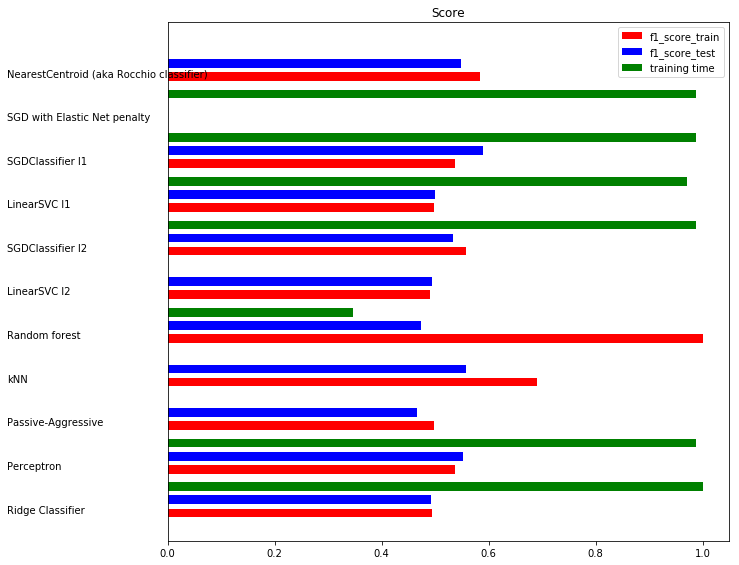

In [598]:
plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, f1_score_train, .2, label="f1_score_train", color='r')
plt.barh(indices+0.3, f1_score_test, .2, label="f1_score_test", color='b')
plt.barh(indices + .6, training_time, .2, label="training time", color='g')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, model_name):
    plt.text(-.3, i, c)

plt.show()

In [ ]:
"""
# Train sparse Naive Bayes classifiers

if (n_components==0):
    print('=' * 80)
    print("Naive Bayes")
    results.append(benchmark(MultinomialNB(alpha=.01)))
    model_name.append("MultinomialNB")
    accuracy.append(accuracy)
    f1_score.append(f1_score)



results.append(benchmark(BernoulliNB(alpha=.01)))
model_name.append("BernoulliNB")
accuracy.append(accuracy)
f1_score.append(f1_score)     
"""


In [281]:
from matplotlib import pyplot as plt
plt.savefig('D:\\Pepsico\\f1score2000.jpeg',bbox_inches = 'tight')
plt.close()

# Saving the model and loading the model with best F1-score

In [581]:
index100=np.argmax(f1_score_test)
print(index100)
f1score100 = f1_score_test[index100]
print(f1score100)
print(model_name[index100])

4
0.8750000000000001
Random forest


In [587]:
index500=np.argmax(f1_score_test)
f1score500 = f1_score_test[index500]
print(f1score500)
print(model_name[index500])

0.5652173913043478
Random forest


In [593]:
index1000=np.argmax(f1_score_test)
f1score1000 = f1_score_test[index1000]
print(f1score1000)
print(model_name[index1000])

0.5737704918032787
SGDClassifier l1


In [599]:
index2000=np.argmax(f1_score_test)
f1score2000 = f1_score_test[index2000]
print(f1score2000)
print(model_name[index2000])

0.5887445887445887
SGDClassifier l1


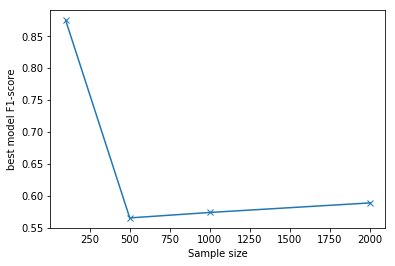

In [600]:
##Plotting the best model f1-scores

import matplotlib.pyplot as plt
plt.plot([100, 500, 1000, 2000],[f1score100,f1score500,f1score1000,f1score2000],marker="x")
#plt.xlim([0,2000])
plt.ylabel('best model F1-score')
plt.xlabel('Sample size')
plt.show()

In [534]:
#model_name

In [535]:
#model

In [601]:
print("Best classifier is:"+model_name[index100],"||f1_score",f1score100)
print("Best classifier is:"+model_name[index500],"||f1_score",f1score500)
print("Best classifier is:"+model_name[index1000],"||f1_score",f1score1000)
print("Best classifier is:"+model_name[index2000],"||f1_score",f1score2000)

Best classifier is:Random forest ||f1_score 0.8750000000000001
Best classifier is:Random forest ||f1_score 0.5652173913043478
Best classifier is:SGDClassifier l1 ||f1_score 0.5737704918032787
Best classifier is:SGDClassifier l1 ||f1_score 0.5887445887445887
